# DAT 612 Final Project 
The Final project will rely more on python packages and libraries instead of R's much-vaunted Recommenderlabs mainly to learn more about other packages besides R's Recommenderlabs package.  To that extent, this is an opportunity to venture out of the book's procedural-driven guidance and discover for ourselves if there are tools out there beside Recomenderlabs one could use to build a recommender systems.  One that has all the nifty built-in libraries as powerful as Recommenderlabs. 

The goal is to evaluate and create an end-to-end recommender system using the movielens data and determine which algorithms produce the best predictive models.

We will attempt multiple recommenders libraries to determine which is most effective. And within data analysis; comparisons of accuracy metrics like RSMEs, ROC and Precision-to-Recall curves will be utilized to determine which ones produces the best result.  "Home-made" IBCF, UBCF and SVD methods will be implemented and tested for accuracies and performance against Python’s Scikit-Learn packaged Turicriate & Surprise libraries. 

The following steps will be applied throughout the project:
- Basic data ETLs followed by standard data exploration and visualizations
- Basic statistical checks of the underlying data
- Training and test split of the datasets
- Hyper-parameter tuning via cross-validation
- Implement the different algorithms/models 
- Comparing accuracy across the datasets per the different algorithms
- Predictive accuracies will rely on Root mean squared error (RMSE). Comparative analysis will be use to determine which models gives the best results via learning/accuracy curves and computational speeds.

Finally, We will perform some random recommendations to see if the recommender systems we have built make some common sense recommendations.

The data sources derived from the 2 MovieLens data sets; ratings and movies tables 

Reference:

(1) Movielens Data source was downloaded from Kaggle website: https://www.kaggle.com/prajitdatta/movielens-100k-dataset?

(2) BUILDING_A_RECOMMENDATION_SYSTEM_WITH_R by Suresh K. Gorakala & Michele Usuelli

In [ ]:
#Loading libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import seaborn as sb
import seaborn as sns
from datetime import datetime
from dateutil.parser import parse
from shapely.geometry import Point, Polygon
%matplotlib inline

import matplotlib
from scipy.sparse.linalg import svds
from numpy.linalg import svd
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
from math import sqrt
#!pip3 install surprise 
import sklearn
#!pip3 install Turicreate
from sklearn.decomposition import TruncatedSVD
from collections import defaultdict
import warnings
from sklearn.metrics.pairwise import pairwise_distances 
warnings.filterwarnings("ignore")


# Loading data tables

- Arranging the ratings & Movies tables and preparing the columns for different genres of movie types

In [ ]:

df = pd.read_csv('https://raw.githubusercontent.com/ssufian/DAT-612/master/Projects/ratings.csv')
movies = pd.read_csv('https://raw.githubusercontent.com/ssufian/DAT-612/master/Projects/movies.csv')


In [ ]:
# After loading the dataset, we should look at the content of each file (ratings, movies).

# Ratings Data
print("\nRatings Data :")
print("shape : ", df.shape)
print(df.head())

# Item Data
print("\nMovies Data :")
print("shape : ", movies.shape)
print(movies.head())


Ratings Data :
shape :  (1048575, 3)
   userId  movieId  rating
0       1      296     5.0
1       1      306     3.5
2       1      307     5.0
3       1      665     5.0
4       1      899     3.5

Movies Data :
shape :  (62423, 3)
   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]


# Basic Data Preparation
- Basic Exploratory analysis

In [ ]:
# merge on movieId=user_id column
data = pd.merge(left=movies, right=df, on='movieId')
data.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0


In [ ]:
data.head(6)
data.shape

(1048575, 5)

In [ ]:
#checking for N/As
data.isnull().sum()

movieId    0
title      0
genres     0
userId     0
rating     0
dtype: int64

In [ ]:
#checking for no. of unique movies

data['movieId'].nunique()

22240

# Exploring Movie Publish Years


In [ ]:
years = []

for title in data['title']:
    year_subset = title[-5:-1]
    try: years.append(int(year_subset))
    except: years.append(9999)
        
data['moviePubYear'] = years
print(len(data[data['moviePubYear'] == 9999]))
# Only 555 movies did not have published years tag on it

555


# Histogram Function

In [ ]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    if attribute == 'moviePubYear':
        dataset = dataset[dataset['moviePubYear'] != 9999]
        
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    sns.set_style("darkgrid",{"axes.facecolor": ".75"})
    
    plt.hist(dataset[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=0)

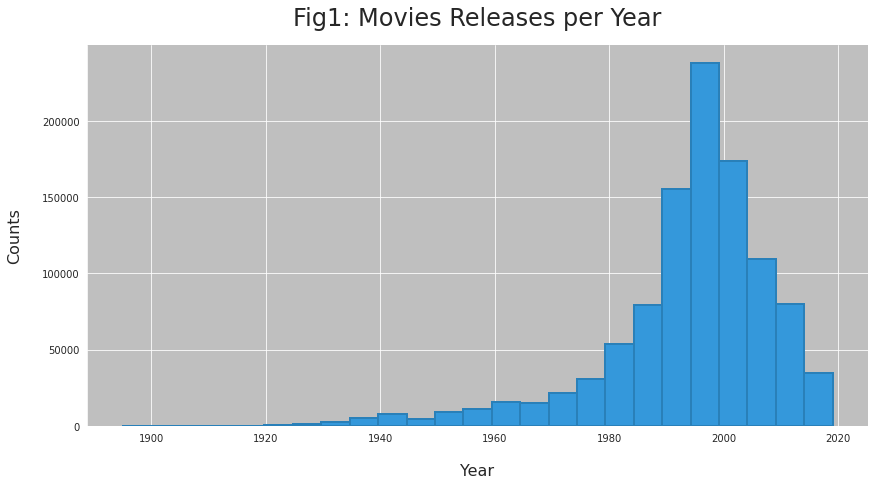

In [ ]:
make_histogram(data, 'moviePubYear', title='Fig1: Movies Releases per Year', xlab='Year', ylab='Counts')

Observation1:  Most movies were released between 1990's to late 200's
# Rating exploration

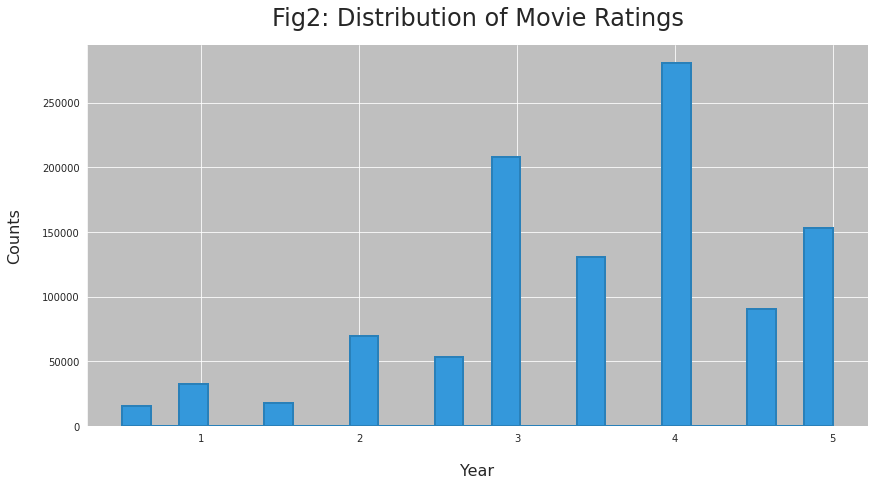

In [ ]:
make_histogram(data, 'rating', title='Fig2: Distribution of Movie Ratings', xlab='Year', ylab='Counts')

Observation2:  Most movies rated at 4 followed by 3 and 5's
# Movie Genre Exploration

- Determining the Number of potential Latent Factors (features)

In [ ]:
genre_df = pd.DataFrame(data['genres'].str.split('|').tolist(), index=data['movieId']).stack()
genre_df = genre_df.reset_index([0, 'movieId'])
genre_df.columns = ['movieId', 'Genre']
genre_df.head()

,movieId,Genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


# Barchart Function


In [ ]:

def make_bar_chart(dataset, attribute, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    if sort_index == False:
        xs = dataset[attribute].value_counts().index
        ys = dataset[attribute].value_counts().values
    else:
        xs = dataset[attribute].value_counts().sort_index().index
        ys = dataset[attribute].value_counts().sort_index().values
        
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.bar(x=xs, height=ys, color=bar_color, edgecolor=edge_color, linewidth=2)
    plt.xticks(rotation=45)

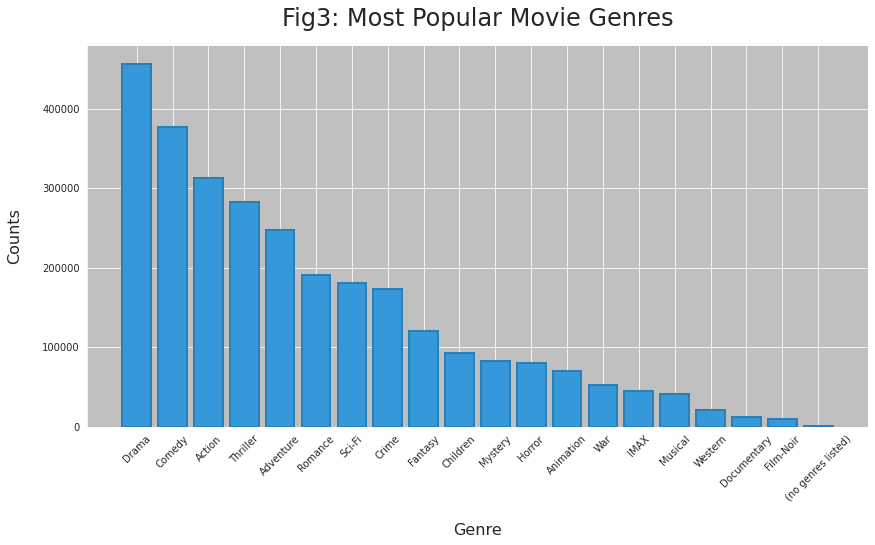

In [ ]:
make_bar_chart(genre_df, 'Genre', title='Fig3: Most Popular Movie Genres', xlab='Genre', ylab='Counts')

Observation3:  19 genres or concepts could be seen when separated into distinct groups of movie types with Drama at the **top**

In [ ]:
values = defaultdict(list)
for ind, row in data.iterrows():
    for genre in row['genres'].split('|'):
        values[genre].append(row['rating'])

genre_lst, rating_lst = [], []
for key, item in values.items():
    if key not in [0, 1]:
        genre_lst.append(key)
        rating_lst.append(np.mean(item))
genres_with_ratings = pd.DataFrame([genre_lst, rating_lst]).T
genres_with_ratings.columns = ['Genre', 'Mean_Rating']


In [ ]:
genres_with_ratings.head()

,Genre,Mean_Rating
0,Adventure,3.51099
1,Animation,3.61612
2,Children,3.43191
3,Comedy,3.42527
4,Fantasy,3.50468


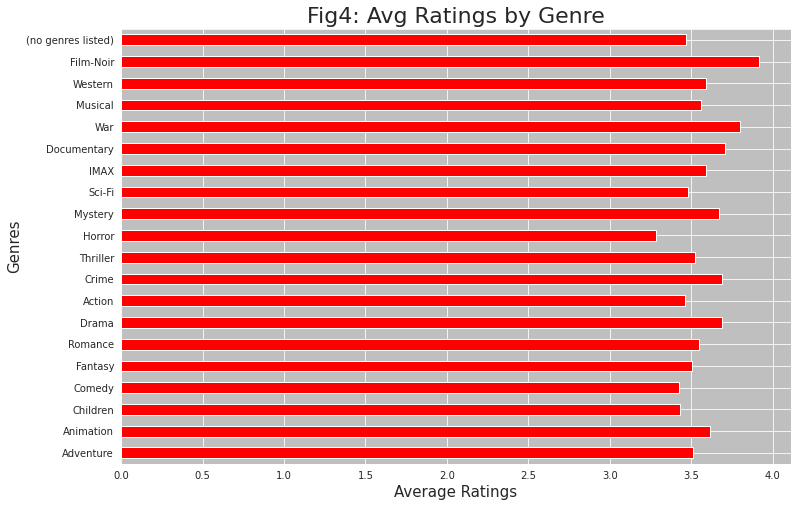

In [ ]:
#setting plot size
plt.rcParams['figure.figsize']=(12,8)   
sns.set_style("darkgrid",{"axes.facecolor": ".75"}) 
 
# Draw a horizontal bar chart
genres_with_ratings.plot.barh(x="Genre", y="Mean_Rating",color='red');
plt.legend('',frameon=False)
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Fig4: Avg Ratings by Genre", fontsize=22)
plt.xlabel("Average Ratings",fontsize=15)
plt.ylabel("Genres",fontsize=15)
plt.show();

Observation4: Film-Noir had the highest average ratins while Horro movies had the lowest
# Visualizing the Number of Ratings


In [ ]:
num_ratings = pd.DataFrame(data.groupby('movieId').count()['rating']).reset_index()
data = pd.merge(left=data, right=num_ratings, on='movieId')
data.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)

In [ ]:
#showing top 10 number of rated movies
data.sort_values(by='numRatings', ascending=False).drop_duplicates('movieId')[:10]

,movieId,title,genres,userId,rating,moviePubYear,numRatings
107840,356,Forrest Gump (1994),Comedy|Drama|Romance|War,600,2.0,1994,3518
93896,318,"Shawshank Redemption, The (1994)",Crime|Drama,2013,4.5,1994,3488
87315,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,5971,4.0,1994,3418
176698,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,3248,5.0,1991,3227
488465,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,5446,1.0,1999,3064
73014,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,2,5.0,1977,2931
140748,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,1977,5.0,1993,2745
152876,527,Schindler's List (1993),Drama|War,3190,1.5,1993,2545
535421,2959,Fight Club (1999),Action|Crime|Drama|Thriller,31,2.0,1999,2530
36974,110,Braveheart (1995),Action|Drama|War,1922,4.0,1995,2516


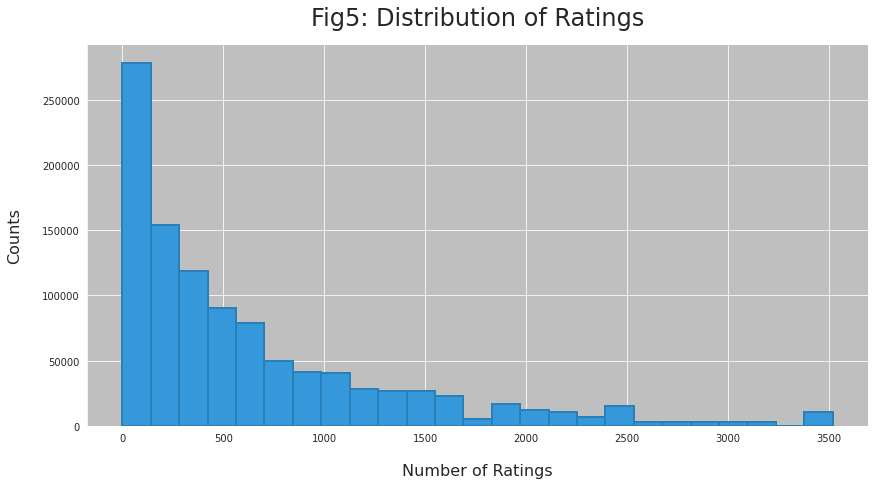

In [ ]:
make_histogram(data, 'numRatings', title='Fig5: Distribution of Ratings', xlab='Number of Ratings', ylab='Counts')

Observation5: As expected most viewers are lazy or have not seen or have not bothered to provide ratings; as such most number of zero ratings are very prevalent
# Scatter Plot: Avg ratings vs.No. of Ratings

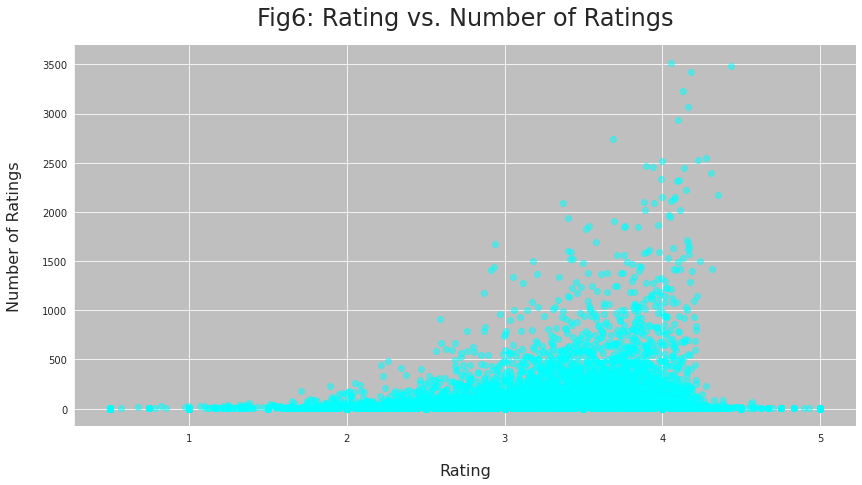

In [ ]:
#setting up for scatter plot
ratings_df = pd.DataFrame()
ratings_df['Mean_Rating'] = data.groupby('title')['rating'].mean().values
ratings_df['Num_Ratings'] = data.groupby('title')['rating'].count().values
#Actual scatter plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Fig6: Rating vs. Number of Ratings', fontsize=24, pad=20)
ax.set_xlabel('Rating', fontsize=16, labelpad=20)
ax.set_ylabel('Number of Ratings', fontsize=16, labelpad=20)

plt.scatter(ratings_df['Mean_Rating'], ratings_df['Num_Ratings'], alpha=0.5,color='cyan');

Observation5: Also as expected, as ratings increases so does the number of raters

# Now to investigate python libraries in order to create an equivalently robust Recommender System using 2 Different Python Packages:
- Turicreate Package
- Surprise Package

# (1) Turicreate library
- Popularity Model
- IBCF Model
- SVD Model
- ALS Model

# Train & Test Data Sets
- Downloaded Training & Testing Data Sets from https://www.kaggle.com/prajitdatta/movielens-100k-datase

In [ ]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_train = pd.read_csv('https://raw.githubusercontent.com/ssufian/DAT-612/master/Projects/ub.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('https://raw.githubusercontent.com/ssufian/DAT-612/master/Projects/ub.test', sep='\t', names=r_cols, encoding='latin-1')
#renaming columns
ratings_train.rename(columns={'user_id': 'userId', 'movie_id': 'movieId'}, inplace=True)
ratings_test.rename(columns={'user_id': 'userId', 'movie_id': 'movieId'}, inplace=True)
#discarding timestamp columns
ratings_train = ratings_train.drop(ratings_train.columns[[3]], axis=1) 
ratings_test = ratings_test.drop(ratings_test.columns[[3]], axis=1) 
ratings_train.shape, ratings_test.shape

((90570, 3), (9430, 3))

In [ ]:
#!pip3 install Turicreate
import turicreate as tc
train_data = tc.SFrame(ratings_train)
test_data = tc.SFrame(ratings_test)
tc.config.set_runtime_config('TURI_DEFAULT_NUM_PYLAMBDA_WORKERS', 40)

# Baseline Model (Popularity Model) Turicreate

- Building a simple popularity and collaborative filtering model using Turicreate

In [ ]:
#Popular model (Baseline model)
popularity_model = tc.popularity_recommender.create(train_data, user_id='userId', item_id='movieId', target='rating')

Preparing data set.

Data has 90570 observations with 943 users and 1675 items.

Data prepared in: 0.081488s

90570 observations to process; with 1675 unique items.

In [ ]:
#Evaluate Popularity Model
popularity_model_tc=popularity_model.evaluate(test_data, target='rating')


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    |          0.0           |          0.0           |
|   3    |          0.0           |          0.0           |
|   4    |          0.0           |          0.0           |
|   5    | 0.00021208907741251324 | 0.00010604453870625662 |
|   6    | 0.00017674089784376103 | 0.00010604453870625662 |
|   7    | 0.0003029843963035903  | 0.00021208907741251316 |
|   8    | 0.00026511134676564165 | 0.00021208907741251305 |
|   9    | 0.00023565453045834803 | 0.00021208907741251327 |
|   10   | 0.00021208907741251327 | 0.00021208907741251327 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0488549712631716

Per User RMSE (best)
+--------+------

#Summary of Popularity Model Turicreate

In [ ]:
rsme_pop_tc=popularity_model_tc['rmse_overall']
precision_recall_df_tcpop=pd.DataFrame (popularity_model_tc['precision_recall_overall']) #converting to Dataframe
precision_recall_df_tcpop['f1-score'] = 2*(precision_recall_df_tcpop['precision'] * precision_recall_df_tcpop['recall'])/(precision_recall_df_tcpop['precision'] + precision_recall_df_tcpop['recall'])#calculating an f1-score
f1_score_pop_tc=precision_recall_df_tcpop[['f1-score']].mean(axis=0)*1 #scale to full percentage value
f1_score_pop_tc_1=f1_score_pop_tc.mean()
# initialize list of lists 
data_pop_tc = [['Turicreate', 'Popularity', rsme_pop_tc,f1_score_pop_tc_1]] 
# Create the summary table
summary_df_pop_tc = pd.DataFrame(data_pop_tc, columns = ['Library', 'Algorithm','RSME','f1-score'])   
# print summary 
summary_df_pop_tc


,Library,Algorithm,RSME,f1-score
0,Turicreate,Popularity,1.048855,0.009772


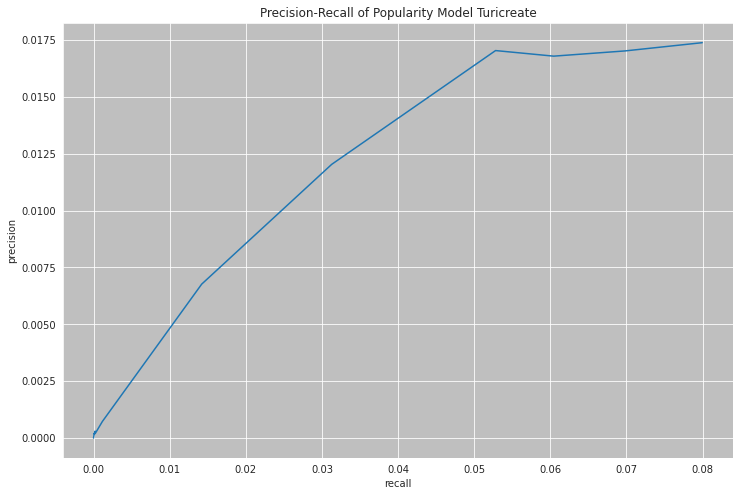

In [ ]:
#Precision-Recall Chart
sns.set_style("darkgrid",{"axes.facecolor": ".75"}) 
ax =precision_recall_df_tcpop.plot(x='recall', y='precision', legend=False,title='Precision-Recall of Popularity Model Turicreate')
ax.set_xlabel("recall")
ax.set_ylabel("precision")
plt.show()

# IBCF Model Turicreate
- After building a popularity model, we will now build a collaborative filtering model
- Train item similarity model (IBCF) and make top 5 recommendations for the first 5 users

In [ ]:
#Training the model- IBCF
item_sim_model = tc.item_similarity_recommender.create(train_data, user_id='userId', item_id='movieId', target='rating', similarity_type='cosine')

Preparing data set.

Data has 90570 observations with 943 users and 1675 items.

Data prepared in: 0.091181s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 10.087ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 16.479ms                            | 0                | 0               |

| 52.915ms                            | 100              | 1675            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.08319s

In [ ]:
# Evaluation of Turicreate's IBCF Model
eval_IBCR_tc = item_sim_model.evaluate(test_data)


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.34040296924708385 | 0.034040296924708426 |
|   2    |  0.2948038176033936 | 0.05896076352067871  |
|   3    | 0.26935312831389224 | 0.08080593849416749  |
|   4    |  0.2449628844114528 | 0.09798515376458108  |
|   5    | 0.22990455991516437 | 0.11495227995758218  |
|   6    | 0.21615411806291973 |  0.1296924708377519  |
|   7    | 0.20390849871231623 |  0.1427359490986214  |
|   8    | 0.19353128313891832 |  0.1548250265111346  |
|   9    |  0.1855779427359492 | 0.16702014846235433  |
|   10   |  0.1783669141039237 |  0.1783669141039237  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.375871715704556

Per User RMSE (best)
+--------+------------------+-------+
| userId |       rmse       | count |
+--------+-

#Summary of IBCF Model Turicreate

In [ ]:
rsme_IBCF_tc=eval_IBCR_tc['rmse_overall']
precision_recall_df_tcIBCF=pd.DataFrame (eval_IBCR_tc['precision_recall_overall']) #converting to Dataframe
precision_recall_df_tcIBCF['f1-score'] = 2*(precision_recall_df_tcIBCF['precision'] * precision_recall_df_tcIBCF['recall'])/(precision_recall_df_tcIBCF['precision'] + precision_recall_df_tcIBCF['recall'])#calculating an f1-score
f1_score_IBCF_tc=precision_recall_df_tcIBCF[['f1-score']].mean(axis=0)*1 #scale to full percentage value
f1_score_IBCF_tc_IBCF=f1_score_IBCF_tc.mean()
# initialize list of lists 
data_IBCF_tc = [['Turicreate', 'IBCF', rsme_IBCF_tc,f1_score_IBCF_tc_IBCF]] 
# Create the summary table
summary_df_IBCF_tc = pd.DataFrame(data_IBCF_tc, columns = ['Library', 'Algorithm','RSME','f1-score'])   
# print summary 
summary_df_IBCF_tc

,Library,Algorithm,RSME,f1-score
0,Turicreate,IBCF,3.375872,0.15362


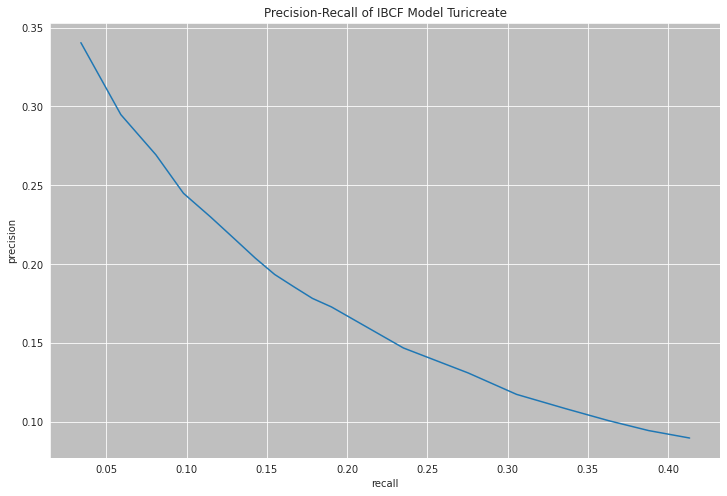

In [ ]:
#Precision-Recall Chart
sns.set_style("darkgrid",{"axes.facecolor": ".75"}) 
ax =precision_recall_df_tcIBCF.plot(x='recall', y='precision', legend=False,title='Precision-Recall of IBCF Model Turicreate')
ax.set_xlabel("recall")
ax.set_ylabel("precision")
plt.show()

# SVD Model Turicreate
- After building a popularity & IBCF model, we will now build an SVD model
- Train SVD and make top 5 recommendations for the first 5 users

In [ ]:
svd_model = tc.factorization_recommender.create(train_data, user_id='userId', item_id='movieId', target='rating')

Preparing data set.

Data has 90570 observations with 943 users and 1675 items.

Data prepared in: 0.083421s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11321 / 90570 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 0.699652                                 |

| 5       | 0.0488281         | 0.721878                                 |

| 6       | 0.0244141         | 0.76665                                  |

| 7       | 0.012207          | 0.830865                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.699652                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 1.26718           | 1.12569               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 356.15ms     | 1.06089           | 1.02999               | 0.0976562   |

| 2       | 678.052ms    | 0.91638           | 0.957272              | 0.0580668   |

| 3       | 995.642ms    | 0.8173            | 0.904038              | 0.042841    |

| 4       | 1.28s        | 0.738544          | 0.859375              | 0.0345267   |

| 5       | 1.59s        | 0.687941          | 0.829408              | 0.029206    |

| 10      | 3.05s        | 0.594713          | 0.771155              | 0.017366    |

| 20      | 6.02s        | 0.547265          | 0.739746              | 0.0103259   |

| 30      | 9.24s        | 0.528892          | 0.727219              | 0.00761832  |

| 40      | 12.63s       | 0.518912          | 0.720323              | 0.00613981  |

| 50      | 16.02s       | 0.512352          | 0.715753              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.489182

Final training RMSE: 0.69938

In [ ]:
#Evaluating SVD 
eval_SVD_tc= svd_model.evaluate(test_data)


Precision and recall summary statistics by cutoff
+--------+----------------------+-----------------------+
| cutoff |    mean_precision    |      mean_recall      |
+--------+----------------------+-----------------------+
|   1    | 0.009544008483563097 | 0.0009544008483563097 |
|   2    |  0.0095440084835631  | 0.0019088016967126198 |
|   3    | 0.011311417462000711 | 0.0033934252386002128 |
|   4    | 0.013785790031813362 |  0.005514316012725346 |
|   5    | 0.013573700954400835 |  0.006786850477200418 |
|   6    | 0.014316012725344643 |  0.00858960763520678  |
|   7    | 0.013785790031813367 |  0.00965005302226934  |
|   8    | 0.014050901378579003 |  0.011240721102863187 |
|   9    | 0.014728408153646731 |  0.013255567338282061 |
|   10   | 0.015482502651113452 |  0.015482502651113452 |
+--------+----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0881275827081647

Per User RMSE (best)
+--------+---------------------+-------+
| userId |       

#Summary of SVD Model Turicreate

In [ ]:
rsme_SVD_tc=eval_SVD_tc['rmse_overall']
precision_recall_df_tcSVD=pd.DataFrame (eval_SVD_tc['precision_recall_overall']) #converting to Dataframe
precision_recall_df_tcSVD['f1-score'] = 2*(precision_recall_df_tcSVD['precision'] * precision_recall_df_tcSVD['recall'])/(precision_recall_df_tcSVD['precision'] + precision_recall_df_tcSVD['recall'])#calculating an f1-score
f1_score_SVD_tc=precision_recall_df_tcSVD[['f1-score']].mean(axis=0)*1 #scale to full percentage value
f1_score_SVD_tc_SVD=f1_score_SVD_tc.mean()
# initialize list of lists 
data_SVD_tc = [['Turicreate', 'SVD', rsme_SVD_tc,f1_score_SVD_tc_SVD]] 
# Create the summary table
summary_df_SVD_tc = pd.DataFrame(data_SVD_tc, columns = ['Library', 'Algorithm','RSME','f1-score'])   
# print summary 
summary_df_SVD_tc

,Library,Algorithm,RSME,f1-score
0,Turicreate,SVD,1.088128,0.015329


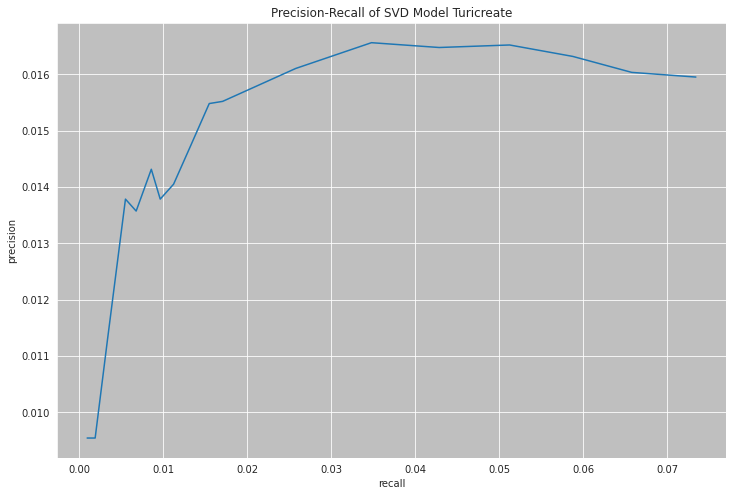

In [ ]:
#Precision-Recall Chart
sns.set_style("darkgrid",{"axes.facecolor": ".75"}) 
ax =precision_recall_df_tcSVD.plot(x='recall', y='precision', legend=False,title='Precision-Recall of SVD Model Turicreate')
ax.set_xlabel("recall")
ax.set_ylabel("precision")
plt.show()

# ALS Model Turicreate
- After building a Popularity, IBCF & SVD model, we will now build our last model:  ALS 
- Train ALS and make top 5 recommendations for the first 5 users

In [ ]:
als_model  = tc.factorization_recommender.create(train_data, user_id='userId', item_id='movieId', target='rating',solver = 'als')

Preparing data set.

Data has 90570 observations with 943 users and 1675 items.

Data prepared in: 0.087363s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 8        |

| regularization               | L2 Regularization on Factors                     | 1e-08    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 54us         | NA                     |

+---------+--------------+------------------------+

| 0       | 71.624ms     | 0.943955               |

| 1       | 139.786ms    | 0.792234               |

| 2       | 208.712ms    | 0.760631               |

| 3       | 262.665ms    | 0.747184               |

| 4       | 307.397ms    | 0.73956                |

| 5       | 354.802ms    | 0.734478               |

| 6       | 402.24ms     | 0.730752               |

| 7       | 434.155ms    | 0.727889               |

| 8       | 469.098ms    | 0.725601               |

| 9       | 505.919ms    | 0.723673               |

| 10      | 537.13ms     | 0.722036               |

| 11      | 578.979ms    | 0.720659               |

| 12      | 625.263ms    | 0.719499               |

| 13      | 651.588ms    | 0.71851                |

| 14      | 669.917ms    | 0.717653               |

| 15      | 689.349ms    | 0.716921               |

| 16      | 718.577ms    | 0.716286               |

| 17      | 745.702ms    | 0.715729               |

| 18      | 763.246ms    | 0.715237               |

| 19      | 778.555ms    | 0.714802               |

| 20      | 793.371ms    | 0.714415               |

| 21      | 827.326ms    | 0.714062               |

| 22      | 868.86ms     | 0.71371                |

| 23      | 921.179ms    | 0.713405               |

| 24      | 944.19ms     | 0.713127               |

| 25      | 962.53ms     | 0.712869               |

| 26      | 978.275ms    | 0.712624               |

| 27      | 1.03s        | 0.712394               |

| 28      | 1.07s        | 0.712175               |

| 29      | 1.10s        | 0.711962               |

| 30      | 1.12s        | 0.711745               |

| 31      | 1.14s        | 0.711555               |

| 32      | 1.16s        | 0.711376               |

| 33      | 1.18s        | 0.711209               |

| 34      | 1.21s        | 0.711052               |

| 35      | 1.23s        | 0.710903               |

| 36      | 1.25s        | 0.71076                |

| 37      | 1.28s        | 0.710623               |

| 38      | 1.29s        | 0.710491               |

| 39      | 1.32s        | 0.710363               |

| 40      | 1.34s        | 0.710238               |

| 41      | 1.38s        | 0.710117               |

| 42      | 1.41s        | 0.709998               |

| 43      | 1.46s        | 0.709884               |

| 44      | 1.48s        | 0.709774               |

| 45      | 1.50s        | 0.709669               |

| 46      | 1.52s        | 0.709568               |

| 47      | 1.54s        | 0.709472               |

| 48      | 1.59s        | 0.70938                |

| 49      | 1.60s        | 0.709292               |

| FINAL   | 1.60s        | 0.709292               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

In [ ]:
#Evaluating ALS
eval_als_tc= als_model.evaluate(test_data)


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    | 0.0010604453870625666 | 0.00010604453870625658 |
|   2    | 0.0010604453870625666 | 0.00021208907741251327 |
|   3    |  0.001060445387062566 | 0.00031813361611876984 |
|   4    |  0.001060445387062567 | 0.0004241781548250264  |
|   5    | 0.0008483563096500532 | 0.0004241781548250266  |
|   6    | 0.0010604453870625662 | 0.0006362672322375399  |
|   7    | 0.0012119375852143617 | 0.0008483563096500531  |
|   8    |  0.001193001060445386 | 0.0009544008483563108  |
|   9    | 0.0011782726522917408 | 0.0010604453870625666  |
|   10   |  0.001166489925768823 |  0.001166489925768823  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 2.77291542360188

Per User RMSE (best)
+--------+--------------------+-

#Summary of ALS Model Turicreate

In [ ]:
rsme_als_tc=eval_als_tc['rmse_overall']
precision_recall_df_tcals=pd.DataFrame(eval_als_tc['precision_recall_overall']) #converting to Dataframe
precision_recall_df_tcals['f1-score'] = 2*(precision_recall_df_tcals['precision'] * precision_recall_df_tcals['recall'])/(precision_recall_df_tcals['precision'] + precision_recall_df_tcals['recall'])#calculating an f1-score
f1_score_als_tc=precision_recall_df_tcals[['f1-score']].mean(axis=0)*1 #scale to full percentage value
f1_score_als_tc_als=f1_score_als_tc.mean()
# initialize list of lists 
data_als_tc = [['Turicreate', 'ALS', rsme_als_tc,f1_score_als_tc_als]] 
# Create the summary table
summary_df_als_tc = pd.DataFrame(data_als_tc, columns = ['Library', 'Algorithm','RSME','f1-score'])   
# print summary 
summary_df_als_tc


,Library,Algorithm,RSME,f1-score
0,Turicreate,ALS,2.772915,0.001028


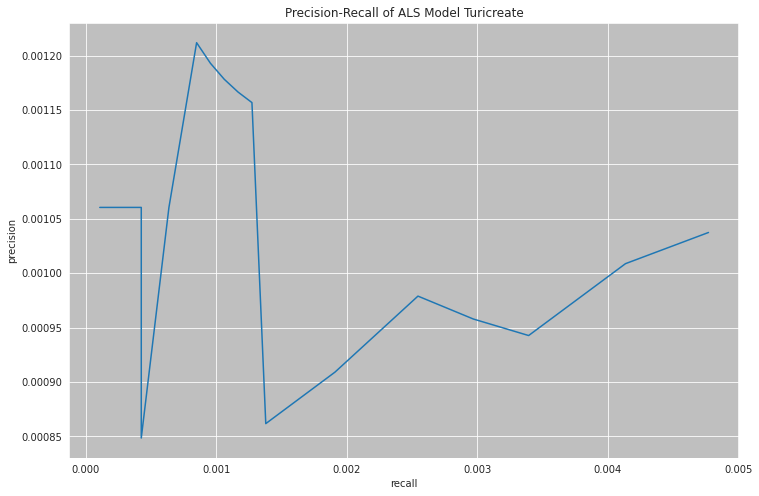

In [ ]:
#Precision-Recall Chart
sns.set_style("darkgrid",{"axes.facecolor": ".75"}) 
ax =precision_recall_df_tcals.plot(x='recall', y='precision', legend=False,title='Precision-Recall of ALS Model Turicreate')
ax.set_xlabel("recall")
ax.set_ylabel("precision")
plt.show()

# (2) The Surprise Library
 
- RSME will be the accuracy metric across all models
- The Best RSME will be used for further evaluation & recommendation purposes

In [ ]:
#!pip3 install surprise
import surprise
from surprise import SVD, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics.pairwise import pairwise_distances 
from surprise.model_selection import cross_validate,KFold
from surprise import accuracy
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
import time
import os


In [ ]:
# Surprise needs df() method & a Reader object to load a dataset from a pandas dataframe
reader = Reader()
data_surprise = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Iterating over all the common Models in Surprise Package
- Model with best RSME will be train for prediction using ALS

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBasic(), KNNWithMeans(), BaselineOnly(),KNNBaseline()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surprise, measures=['RMSE'], cv=3, verbose=False)
     # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
#Benchmarking the best RSMEs
benchmark_surprise =pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
benchmark_surprise_df= benchmark_surprise .rename_axis(index='Algorithm', columns="Surprise Library")
benchmark_surprise_df


Surprise Library,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.845517,38.652363,3.749910
KNNBaseline,0.858729,24.321308,150.330441
BaselineOnly,0.867356,3.711752,3.578935
KNNWithMeans,0.882348,21.857745,144.011021
KNNBasic,0.911056,22.009556,140.372704


# Train and Predict Surprise Algorithm

- SVD model had the best RSME, therefore, we will train and predict with this
model using Stochastic Gradient Descent Method (SGD) to get better RSME?
- Note: Could not re-use Turicreate's Train/Test split data sets in Surprise because the set-up is different in this particular package
- Using a 10% test size to mimic closely to the Turicreate's Train/Test split Schema ratio

In [ ]:
#Creating training and test data sets in Surprise
trainset, testset = train_test_split(data_surprise , test_size=0.10)

#SVD Model Surprise
algo = SVD(random_state=0, n_factors=200, n_epochs=30, verbose=True)

start_time = time.time()
algo.fit(trainset);

train_time = time.time() - start_time
print("Took {} seconds for training.".format(train_time))


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Took 132.55686235427856 seconds for training.


In [ ]:
#Making prediction in Surprise
predictions = algo.test(testset)
predictions[0:5] #raw output of predictions from Surprise package

In [ ]:
#Evaluating accuracy in Surprise
accuracy.rmse(predictions)

RMSE: 0.8306


0.8305930742862689

- Stochastic Gradient Descent Method (SGD) did not improve the SVD Surpise model significantly even after increasing the n-factors & iterations (epochs)

# Building collaborative filtering models from scratch: IBCF & UBCF

- These *Home made* Item-based & User based collaborative filtering recipes were inspired from the following blogs:

1) https://blog.cambridgespark.com/nowadays-recommender-systems-are-used-to-personalize-your-experience-on-the-web-telling-you-what-120f39b89c3c

2) https://medium.com/sfu-cspmp/recommendation-systems-user-based-collaborative-filtering-using-n-nearest-neighbors-bf7361dc24e0

In [ ]:
#calculate the number of unique users and movies from original ratings matrix
n_users = df.userId.unique().shape[0]
n_items = df.movieId.unique().shape[0]

In [ ]:
#create 2 user item matrices of type np arrays for training and for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in ratings_train.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in ratings_test.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [ ]:
#Calculate Cosine Similarity
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

# Making Predictions with IBCF & UBCF

In [ ]:
#Prediction Function
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [ ]:
#Making Prediction
user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')

# Evaluation of IBCF & UBCF Models

- Calculating its RSMEs

In [ ]:
#Function to compute RSMEs
def rsme(prediction, ground_truth):
  prediction = prediction[ground_truth.nonzero()].flatten()
  ground_truth= ground_truth[ground_truth.nonzero()].flatten()
  return sqrt(mean_squared_error(prediction,ground_truth))

In [ ]:
print('User-Based CF RSME:' + str(rsme(user_prediction ,test_data_matrix)))
print('Item-Based CF RSME:' + str(rsme(item_prediction ,test_data_matrix)))

User-Based CF RSME:3.6786858618357567
Item-Based CF RSME:3.7506771657664837


# Lastly, a *Homemade* Truncated SVD was implemented to complete the anaylsis
- Using Scikit-Learn to easily run the SVD decomposition into 19 latent factors, i.e. the 19 most popular different genre types from Figure 3
- Using **Un-normalized **Utility-Matrix as starting baseline to perform Truncated SVD Analysis

In [ ]:
movie_names = movies[['movieId', 'title']]
combined_movies_data = pd.merge(df, movie_names, on='movieId')
combined_movies_data.head()

,userId,movieId,rating,title
0,1,296,5.0,Pulp Fiction (1994)
1,3,296,5.0,Pulp Fiction (1994)
2,4,296,4.0,Pulp Fiction (1994)
3,5,296,4.0,Pulp Fiction (1994)
4,7,296,4.0,Pulp Fiction (1994)


# Pivot data

- Create a Utility Matrix

In [ ]:
#User-Item Matrix
rating_crosstab = combined_movies_data.pivot_table(values='rating', index='userId', columns='title', fill_value=0)
rating_crosstab.head()

In [ ]:
rating_crosstab.shape #checking shape only

(7045, 22226)

# Transposing Table 
- Making an Item-Item based Table
- Transpose of Utility Matrix makes rows into movies & columns into users

In [ ]:
#Transpose of Utility Matrix 
# X is now the Item-Item Matrix
X = rating_crosstab.T
X.head()

In [ ]:
#Fitting using SVD fit function
SVD = TruncatedSVD(n_components=19, random_state=5)# no. of component reflects the 19 popular genres from Figure 3
US = SVD.fit_transform(X)

In [ ]:
# Components of Truncated SVD decompositions
V=SVD.components_
S=SVD.singular_values_ 


In [ ]:
print(SVD.explained_variance_ratio_)

print(SVD.explained_variance_ratio_.sum())

print(SVD.singular_values_)

[0.1709174  0.04140253 0.02255414 0.01834604 0.01310272 0.01220618
 0.01210197 0.00830936 0.00737263 0.00600173 0.00574443 0.00561504
 0.0053616  0.00486073 0.00425798 0.00399086 0.00373938 0.00358966
 0.0033958 ]
0.35287016488969386
[1623.53535391  761.24674545  565.52498996  521.72269687  441.82085731
  413.43904411  413.30138312  341.17361809  321.89525836  290.3289482
  285.31944747  280.80787037  273.90536109  260.79374624  244.35652549
  237.00556378  230.46567818  224.55165045  219.98369457]


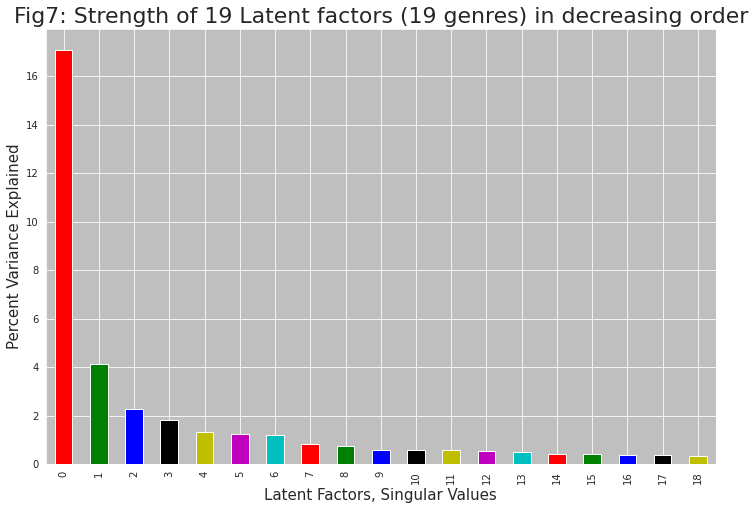

In [221]:
# converting matrix to dataframe for plotting purposes only
var_ = pd.DataFrame(SVD.explained_variance_ratio_*100)
var_.columns = ['variance']
var_.index.names = ['factors']
#setting plot size
plt.rcParams['figure.figsize']=(12,8)
my_colors = 'rgbkymc'    
sns.set_style("darkgrid",{"axes.facecolor": ".75"}) 
 
var_[:20].plot(kind="bar",color=my_colors)
plt.legend('',frameon=False)
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("Fig7: Strength of 19 Latent factors (19 genres) in decreasing order", fontsize=22)
plt.xlabel("Latent Factors, Singular Values",fontsize=15)
plt.ylabel("Percent Variance Explained",fontsize=15)
plt.show()

In [ ]:
#Conversion of original utility matrix into numpy array format
R = rating_crosstab.to_numpy()

In [ ]:
#Manually decomposing the Matrices
U, singularValues, V = svd(R, full_matrices=False)

In [ ]:
#checking out shapes 
print(U.shape)
print(singularValues.shape)
print(V.shape)

(7045, 7045)
(7045,)
(7045, 22226)


In [ ]:
Sigma = np.diag(singularValues) #making singular value matrix, a diagonal matrix

In [ ]:
#subsetting U,V and Singular Matrix to get only the first Top 19 Singular values of importance(genres)
# picking up only the first 20 columns of U
Ucolumns = U[: , 0:19]
Ucolumns
# picking up only the first 20 rows of V^t
Vrows = V[0:19,:]
Vrows
# picking up only the first 20 columns & rows of the Singular Matrix; Sigma
Sigma2 = Sigma [0:19 , 0:19]

# R' Predicted Ratings Matrix

In [ ]:
# Predicted matrix via dot product
Rprime = np.dot(Ucolumns, np.dot(Sigma2, Vrows))

In [ ]:
#RSME computation
rmse_visual = sqrt(mean_squared_error(R, Rprime))
print("The RSME of the 'Home-made' SVD Decompoistion :")  
print(rmse_visual)

The RSME of the 'Home-made' SVD Decompoistion :
0.24052143818702512


# Results of analysis:
- Using RSME as a common accuracy benchmark: SVD models from the various libraries were the best overall.  Therefore, forward recommendations will be made only from the SVD models from each library

1.   SVD Turicreate
2.   SVD Surprise
3.   "Home-made" SVD



# Recommendation of SVD Turicreate Library
- Using the Top 2 best RSMEs
- Popularity Model (RSME: 1.05)* 
- SVD Model (RSME: 1.09)

 **Although the Turicreate's Popularity model had a slightly better RSME, it's recommendation was not personalized**.  So it was better to use the SVD as it has a personalized recommendation, i.e., not all ratings were fictiously ranked as 5

In [ ]:
# (1) Sample of Recomendations using SVD Turicreate from several users 
svd_model_recomm = svd_model.recommend(users=[1,2,3,4,5],k=5)
svd_model_recomm.print_rows(num_rows=25)

+--------+---------+--------------------+------+
| userId | movieId |       score        | rank |
+--------+---------+--------------------+------+
|   1    |   512   | 5.9772432452981885 |  1   |
|   1    |   647   | 5.6786428100412305 |  2   |
|   1    |   641   | 5.517927706891816  |  3   |
|   1    |   1405  | 5.464299262220186  |  4   |
|   1    |   1473  | 5.452668250257295  |  5   |
|   2    |   1142  | 6.261413118520897  |  1   |
|   2    |   641   | 5.904053232351464  |  2   |
|   2    |   605   | 5.897570869604271  |  3   |
|   2    |   661   | 5.894659063497704  |  4   |
|   2    |   197   | 5.767032406011742  |  5   |
|   3    |   1268  | 5.529076100045961  |  1   |
|   3    |   1019  | 5.442131519967836  |  2   |
|   3    |   295   | 5.374753237420839  |  3   |
|   3    |   1143  | 5.227024794275087  |  4   |
|   3    |   962   | 5.111362934762758  |  5   |
|   4    |   344   | 6.8112422234361585 |  1   |
|   4    |   486   | 6.525071025544923  |  2   |
|   4    |   107   |

In [ ]:
svd_model_recomm_df = pd.DataFrame(svd_model_recomm)#converting to Dataframe
recommend_movies_SVD_tc = pd.merge(svd_model_recomm_df, data, on='movieId')

In [ ]:
#Sort by highest rated movies from recommended SVD list
recommend_movies_SVD_tc.sort_values(by=['rating'], inplace=True, ascending=False)
recommend_movies_SVD_tc.head() 

,userId_x,movieId,score,rank,title,genres,userId_y,rating,moviePubYear,numRatings
1468,3,1019,5.442132,2,"20,000 Leagues Under the Sea (1954)",Adventure|Drama|Sci-Fi,1392,5.0,1954,238
2904,4,344,6.811242,1,Ace Ventura: Pet Detective (1994),Comedy,5071,5.0,1994,1676
4433,5,919,5.640115,5,"Wizard of Oz, The (1939)",Adventure|Children|Fantasy|Musical,3623,5.0,1939,1048
2821,4,344,6.811242,1,Ace Ventura: Pet Detective (1994),Comedy,4722,5.0,1994,1676
4930,5,919,5.640115,5,"Wizard of Oz, The (1939)",Adventure|Children|Fantasy|Musical,6969,5.0,1939,1048


In [ ]:
view_unique_title_SVD_tc= pd.DataFrame(recommend_movies_SVD_tc.title.unique())
view_unique_title_SVD_tc.rename(columns={0: 'Movies'}, inplace=True)
view_unique_title_SVD_tc

,Movies
0,"20,000 Leagues Under the Sea (1954)"
1,Ace Ventura: Pet Detective (1994)
2,"Wizard of Oz, The (1939)"
3,"Puppet Masters, The (1994)"
4,One Fine Day (1996)
5,Muppet Treasure Island (1996)
6,Courage Under Fire (1996)
7,James and the Giant Peach (1996)
8,Ninotchka (1939)
9,Beavis and Butt-Head Do America (1996)


# Recommendation of SVD Surprise Library
# Data table of Top 10 and Bottom 10 predictions Surprise Package
- Predictions in detailed Tablular format
- This nice function borrowed from a blog by Nicolas Hug: https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df1 = pd.DataFrame(predictions, columns=['uid', 'iid', 'r_ui', 'est', 'details'])
df1['Iu'] = df1.uid.apply(get_Iu)
df1['Ui'] = df1.iid.apply(get_Ui)
df1['err'] = abs(df1.est - df1.r_ui)
best_predictions = df1.sort_values(by='err')[:10]
worst_predictions = df1.sort_values(by='err')[-10:]

In [ ]:
#Overall Prediction from Surprise Package
df1.head()

,uid,iid,r_ui,est,details,Iu,Ui,err
0,4152,318,5.0,4.216895,{'was_impossible': False},406,3138,0.783105
1,3274,2174,4.0,4.429163,{'was_impossible': False},530,775,0.429163
2,3765,6440,4.0,4.139689,{'was_impossible': False},32,157,0.139689
3,3028,3107,4.0,4.049894,{'was_impossible': False},508,275,0.049894
4,5019,2858,4.0,3.661529,{'was_impossible': False},284,1986,0.338471


In [ ]:
#Overall Best Prediction from Surprise Package
best_predictions

,uid,iid,r_ui,est,details,Iu,Ui,err
26333,648,57640,1.0,1.0,{'was_impossible': False},613,172,0.0
77446,6185,79132,5.0,5.0,{'was_impossible': False},31,1470,0.0
34342,1039,104879,5.0,5.0,{'was_impossible': False},37,212,0.0
77801,5126,2194,5.0,5.0,{'was_impossible': False},828,595,0.0
77950,3379,2959,5.0,5.0,{'was_impossible': False},117,2288,0.0
77971,1869,3508,5.0,5.0,{'was_impossible': False},419,132,0.0
78187,1494,1207,5.0,5.0,{'was_impossible': False},152,620,0.0
8795,5852,193,1.0,1.0,{'was_impossible': False},284,291,0.0
8752,4775,160,1.0,1.0,{'was_impossible': False},1196,563,0.0
77365,5596,3949,5.0,5.0,{'was_impossible': False},107,821,0.0


In [ ]:
#Overall Worst Prediction from Surprise Package
worst_predictions

,uid,iid,r_ui,est,details,Iu,Ui,err
83777,1554,5669,0.5,4.413977,{'was_impossible': False},96,511,3.913977
96219,3857,89492,0.5,4.435734,{'was_impossible': False},205,244,3.935734
39337,4292,3461,0.5,4.443518,{'was_impossible': False},28,94,3.943518
32509,2497,53000,0.5,4.457342,{'was_impossible': False},93,176,3.957342
61329,4638,7786,0.5,4.470164,{'was_impossible': False},243,4,3.970164
88785,709,156387,1.0,5.000000,{'was_impossible': False},419,33,4.000000
93421,6444,908,0.5,4.504454,{'was_impossible': False},91,635,4.004454
40265,134,1225,0.5,4.557013,{'was_impossible': False},62,776,4.057013
56637,1736,58425,0.5,4.634878,{'was_impossible': False},147,8,4.134878
79367,210,53894,0.5,4.750710,{'was_impossible': False},30,90,4.250710


In [ ]:
# Rootcausing as to why certain prediction was so off?
tt1=df1[df1.iid == 1225]
tt1.head()

,uid,iid,r_ui,est,details,Iu,Ui,err
1569,5064,1225,4.0,3.620663,{'was_impossible': False},1043,776,0.379337
2805,2480,1225,4.0,4.025972,{'was_impossible': False},290,776,0.025972
3532,1127,1225,3.5,4.195754,{'was_impossible': False},111,776,0.695754
4366,5588,1225,5.0,4.050624,{'was_impossible': False},313,776,0.949376
5823,1756,1225,5.0,4.549970,{'was_impossible': False},146,776,0.450030


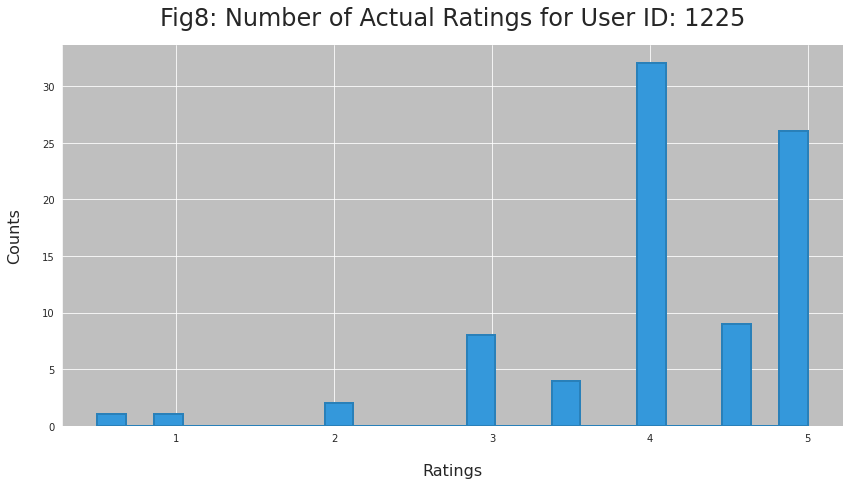

In [222]:
make_histogram(tt1, 'r_ui', title='Fig8: Number of Actual Ratings for User ID: 1225', xlab='Ratings', ylab='Counts')

- As an example, user ID 1225 the numbers around this user has given high ratings, so we are screwed.  The only way to avoid this kind of errors would be to increase the min_k parameter, but it would actually worsen the accuracy as part of the trade-off.

#SVD Surprise's Top ten most accurate (by RSME) movies recommendations

In [220]:
best_predictions1=best_predictions.rename(columns = {'iid':'movieId'}) 
recommend_movies_SVD_surprise = pd.merge(best_predictions1, movies, on='movieId')
recommend_movies_SVD_surprise.iloc[:,[1,8]]

,movieId,title
0,57640,Hellboy II: The Golden Army (2008)
1,79132,Inception (2010)
2,104879,Prisoners (2013)
3,2194,"Untouchables, The (1987)"
4,2959,Fight Club (1999)
5,3508,"Outlaw Josey Wales, The (1976)"
6,1207,To Kill a Mockingbird (1962)
7,193,Showgirls (1995)
8,160,Congo (1995)
9,3949,Requiem for a Dream (2000)


# Because the Home-made Truncated SVD model had better RSME relative to the other Home-made IBCF & UBCF models, we will use SVD only to make recommendations 

In [ ]:
#Correlation Matrix based on Truncated SVD with K=19
corr_mat = np.corrcoef(US)
corr_mat

array([[ 1.        ,  0.31779739,  0.09300139, ...,  0.24880762,
         0.26576639,  0.52623517],
       [ 0.31779739,  1.        ,  0.10009203, ...,  0.37626835,
         0.16672367,  0.38657806],
       [ 0.09300139,  0.10009203,  1.        , ..., -0.03910081,
        -0.2511084 , -0.11844646],
       ...,
       [ 0.24880762,  0.37626835, -0.03910081, ...,  1.        ,
         0.81602406,  0.62903955],
       [ 0.26576639,  0.16672367, -0.2511084 , ...,  0.81602406,
         1.        ,  0.61434838],
       [ 0.52623517,  0.38657806, -0.11844646, ...,  0.62903955,
         0.61434838,  1.        ]])

In [ ]:
# Function to check for similar movies
def get_similar_item(movie):
    movie_input =str(movie)
    col_idx = rating_crosstab.columns.get_loc(movie_input)
    corr_specific = corr_mat[col_idx]
    df_similar_movie=pd.DataFrame({'corr_specific':corr_specific, 'Movies': rating_crosstab.columns})\
    .sort_values('corr_specific', ascending=False).head(10)# selecting only Top 10 similar movies
    return print(df_similar_movie)

In [ ]:
# Check to see if similar movies are what it should be or not
check_similar_movie=get_similar_item("Pulp Fiction (1994)")

       corr_specific                                             Movies
15023       1.000000                                Pulp Fiction (1994)
20812       0.970633                         Usual Suspects, The (1995)
16487       0.952377                        Seven (a.k.a. Se7en) (1995)
16812       0.949880                   Silence of the Lambs, The (1991)
16632       0.944143                   Shawshank Redemption, The (1994)
11582       0.905663  Léon: The Professional (a.k.a. The Professiona...
16248       0.889311                            Schindler's List (1993)
6897        0.870543                                Forrest Gump (1994)
13130       0.869571                        Natural Born Killers (1994)
2946        0.852518                                  Braveheart (1995)


- We are going to take a different tack against the typical recomendation from the 2 previous methods; Turicreate & Surprise

- Here, we give end user the ability to pick similar movies ranked by correlation and allow them to make the top 10 recommendation themselves

For instance, every movie has a 100% Correlation Pearson with itself as expected. With the Item-Based collaborative filtered we can recommend movies based on user preference. For example, if someone likes the “Pulp Fiction (1994)” we can recommend him to watch the ” Usual Suspects, The (1995)“. It works also on the other way around. If someone does not like the ” Star Wars (1977)” we can suggest him to avoid watching the “Return of the Jedi (1983)“




#Summary
- Because this was an educational data set:

1.   The data ETLs and statiscical analysis were fairly straighfoward and seamless
2.   The findings were all very intuitive with most movies having no ratings as viewers just don't want to be bothere with ratings, highly rated movies have most numbers of raters and lastly majority of movies were released in the mid to late 2000s.

- Python libraries; Turicreate & Surprise were utilized for this experiment

1.   Turicreate has most of the functionalites and built-in packages similar to Recommenderlabs.  However, its evaluation functionalities such as ROC and Precision-to-Recall curves capabilities were inferior; it requires that predicted values be integers and a fair manual work to just perform similar categorical evaluations like Recommenderlab
2.   Surprise does NOT have any of the evaluation functionalities anywhere close to Recommenderlab except for RSME computation.  

Given these deficiencies of the libraries, I had to find a common denominator to compare accuracies across all these models and the only common metrics common to all was RSME which formed the basis of my comparision.

- Best Models from each methodologies:

1.   SVD model had the best RSME was used for recommendation purposes
2.   Due to differences in set-ups within each library, training and test sets were not quite the same; which could explain item 3 below
3.   None of the recommended movies match out from one library to another while the Home-made SVD utilized a total differnt strategy altogether

#Conclusion
Although it took me quite a bit to put all this together, it was worth the effort to learn and discover along the way all the intricacies of building a recommender system.  Having said that, this project took me through a myriad of investigative routes to discover and learn for myself how difficult it was to use other libraries outside of recommenderlab.  These other libraries did not have all the nifty built-in routines Reommenderlab has and it took quite a bit of manipulations to put all the necessary statistical accuracy metrics together not to mention makinng the necessary predictions and recommendations. 